In [5]:
!pip install streamlit crewai-tools crewai google-search-results git+https://github.com/openai/swarm.git langchain-community duckduckgo-search onnxruntime langgraph datasets matplotlib openai-agents

  Cloning https://github.com/openai/swarm.git to /tmp/pip-req-build-2ecloy1d
  Running command git clone --filter=blob:none --quiet https://github.com/openai/swarm.git /tmp/pip-req-build-2ecloy1d
  Resolved https://github.com/openai/swarm.git to commit 0c82d7d868bb8e2d380dfd2a319b5c3a1f4c0cb9
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 kB 3.6 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of openai-agents to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 5.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     

# Setting up a basic ReAct Agent in LangGraph

In [13]:



import os
from google.colab import userdata

os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')
os.environ["SERPAPI_API_KEY"] = userdata.get('SERPAPI_API_KEY')  # https://serpapi.com for a free token!

In [14]:
from langchain_community.agent_toolkits.load_tools import load_tools
tools = load_tools(["serpapi"])


In [9]:
tools[0].run('Harold Affo')

'[\'I am a software engineering and machine learning leader combining experience leading… · Experience: YouTube · Education: Stanford University Graduate School ...\', "Harold Affo\'s Post. View profile for Harold Affo. Harold Affo. Engineering Leader @ Google | Software & ML Engineering | Generative AI ...", \'Harold Affo ; Modern house ideas · 7 Pins · 10mo ; 3576 · 13 Pins · 2y ; Little black boy haircuts · 2 Pins · 3y ; Soup · 1 Pin · 7y.\', "I\'m no epidemiologist and no public health expert. I do believe passionately in science and also in #Factfulness. This man is the global authority on the spread ...", \'Gen AI, Software Architect, Entrepreneur, Tech Enthusiast. 4 followers · 2 following. DC; https://haroldaffo.com · @afrold ...\', \'Harold Affo. @haroldaffo5335. More about this channel ...more ...more. Subscribe. Home. Playlists ... Appian. Harold Affo · Playlist.\', "Explore Harold AFFO\'s 2 photos on Flickr ... Harold AFFO. afrold. 4 Followers•2 Following. 2 Photos. Joined 

In [17]:
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import create_react_agent

# Choose the LLM that will drive the agent
llm = ChatOpenAI(model="gpt-4o-mini")
agent_executor = create_react_agent(llm, tools)  # true as of 5/30/2025 ;)

In [18]:
response = agent_executor.invoke({"messages": [("user", "Who is the current Ravens QB?")]})

In [19]:
response['messages'][-1].content

'The current quarterback for the Baltimore Ravens is Lamar Jackson.'

In [20]:
# if I didn't put the date in, it would use a past year like 2023 as thr query instead of
#  {"query":"current Baltimore Ravens quarterback 2025"}
for event in agent_executor.stream({"messages": [("user", "Who is the current Ravens QB?")]}):
    print(event)


{'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_fymIfcyl5wCos8KdJu1gps4P', 'function': {'arguments': '{"__arg1":"current Baltimore Ravens quarterback 2023"}', 'name': 'Search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 73, 'total_tokens': 94, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--58b8e820-64cc-4f93-a679-5f67c3428f34-0', tool_calls=[{'name': 'Search', 'args': {'__arg1': 'current Baltimore Ravens quarterback 2023'}, 'id': 'call_fymIfcyl5wCos8KdJu1gps4P', 'type': 'tool_call'}], usage_metadata={'input_tokens': 73, 'output_tokens': 21, 'total_tokens': 94, 'input_token_det

In [21]:
print(event['agent']['messages'][-1].content)

The current quarterback for the Baltimore Ravens is Lamar Jackson.


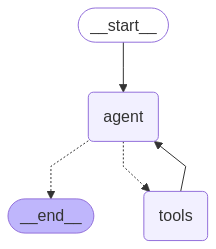

In [22]:
# Compile the graph
from IPython.display import Image, display

display(Image(agent_executor.get_graph().draw_mermaid_png()))

In [23]:
response = agent_executor.invoke({"messages": [("user", "Who is Sinan Ozdemir?")]})

print(response['messages'][-1].content)

Sinan Ozdemir is a data scientist, entrepreneur, and author based in the San Francisco Bay Area. He has a background in pure mathematics, having studied at Johns Hopkins University. Ozdemir specializes in artificial intelligence (AI), natural language processing (NLP), and data science. He is known for founding a company called LoopGenius, which assists businesses in gaining their first customers. Additionally, he has written books on essential math and coding skills for data fluency and machine learning. Ozdemir is also recognized for his contributions to platforms like Forbes and has experience as a lecturer and consultant in AI technology.


# Turn our ReAct Agent into a Chat

In [24]:
from langgraph.graph import MessagesState, END, StateGraph, START
from langchain_core.messages import HumanMessage, AIMessage

In [26]:
class ConvoState(MessagesState):
    # MessagesState already has messages in it
    end: bool

def get_user_input(state):
    user_msg = input("\n🧑 You: ")
    if user_msg.strip().lower() == "exit":
        return {'end': True}
    return {"messages": HumanMessage(content=user_msg)}

def run_agent(state):
    print(f'num of messages: {len(state["messages"])}')
    response = agent_executor.invoke({"messages": state["messages"]})
    print(f"\n🤖 Agent: {response['messages'][-1].content}")
    # print(f'num of messages: {len(response['messages'])}')
    return {"messages": response['messages'][len(state['messages']):]}

graph_builder = StateGraph(ConvoState)
graph_builder.add_node("get_user_input", get_user_input)
graph_builder.add_node("run_agent", run_agent)

graph_builder.set_entry_point("get_user_input")
graph_builder.add_conditional_edges(
    "get_user_input",
    lambda state: 'end' if state.get('end') else 'go',
    {
        'end': END,
        'go': 'run_agent'
    }
)
graph_builder.add_edge("run_agent", "get_user_input")

graph = graph_builder.compile()

In [27]:

print("💬 Start chatting with the agent! Type 'exit' to stop.")
state = graph.invoke({"messages": []})

💬 Start chatting with the agent! Type 'exit' to stop.

🧑 You: hi
num of messages: 1

🤖 Agent: Hello! How can I assist you today?

🧑 You: who was the last president of benin
num of messages: 3

🤖 Agent: The current president of Benin is Patrice Talon, who has been in office since April 6, 2016. He was re-elected in 2021.

🧑 You: before him
num of messages: 7

🤖 Agent: Before Patrice Talon, the president of Benin was Thomas Boni Yayi, who served from June 4, 2006, to April 6, 2016.

🧑 You: end
num of messages: 11

🤖 Agent: If you have any more questions in the future, feel free to ask. Have a great day!

🧑 You: exit


In [ ]:
for message in state['messages']:
    print(type(message), message.content, 'Tool ID:' + message.tool_call_id if hasattr(message, 'tool_call_id') else '')
    if message.additional_kwargs.get('tool_calls'):
        tool_calls = message.additional_kwargs.get('tool_calls')
        for tool_call in tool_calls:
            print(f'Tool Call: ID({tool_call["id"]}), Name({tool_call["function"]["name"]}), Args({tool_call["function"]["arguments"]})')
    elif hasattr(message, 'tool_calls'):
        tool_calls = message.tool_calls
        for tool_call in tool_calls:
            print(f'Tool Call: ID({tool_call["id"]}), Name({tool_call["name"]}), Args({tool_call["args"]})')
    print('----')

<class 'langchain_core.messages.human.HumanMessage'> hi 
----
<class 'langchain_core.messages.ai.AIMessage'> Hello! How can I assist you today? 
----
<class 'langchain_core.messages.human.HumanMessage'> weather in sf please 
----
<class 'langchain_core.messages.ai.AIMessage'>  
Tool Call: ID(call_i56kZkkVF3KvKzi3479nqjzd), Name(Search), Args({"__arg1":"current weather in San Francisco"})
----
<class 'langchain_core.messages.tool.ToolMessage'> {'type': 'weather_result', 'temperature': '68', 'unit': 'Fahrenheit', 'precipitation': '0%', 'humidity': '67%', 'wind': '10 mph', 'location': 'San Francisco, CA', 'date': 'Friday 2:00 PM', 'weather': 'Partly cloudy'} Tool ID:call_i56kZkkVF3KvKzi3479nqjzd
----
<class 'langchain_core.messages.ai.AIMessage'> The current weather in San Francisco is partly cloudy with a temperature of 68°F. The humidity is at 67%, and there's no precipitation expected. There's a light wind blowing at 10 mph. 
----
<class 'langchain_core.messages.human.HumanMessage'> th

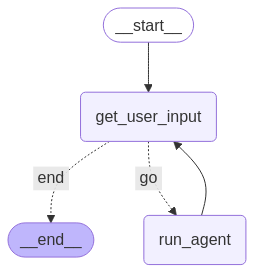

In [ ]:
# Compile the graph
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))